# Análisis de tweets - Big Data
## Debates electorales

Pedro Pons Suñer

In [1]:
import pymongo
import json
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
import datetime
import numpy as np
import pandas as pd
import time
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

In [20]:
# Se establece la conexión con MongoDB. BBDD: TwitterStream
connection = pymongo.MongoClient('localhost', 27017)
db = connection.TwitterStream
db.RTVE.ensure_index("id", unique=True, dropDups=True)
collection = db.RTVE

cursor = collection.find(no_cursor_timeout=True) 

C:\Users\R510V\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: ensure_index is deprecated. Use create_index instead.
  after removing the cwd from sys.path.


## Términos más repetidos

En este apartado se generarán nubes de palabras o "wordclouds" a partir del texto de los tweets colectados durante el debate en RTVE del día 22 de abril, primero analizando todos los tweets y después realizando algunas búsquedas más concretas:

In [3]:
#Función para concatenar el texto de todos los tweets de forma rápida
def getTexto(query={}):
    cursor = collection.find(query,no_cursor_timeout=True)
    texto=''
    marcapaginas=0
    it=0
    textoTotal=''
    lenTotal=cursor.count()
    limite=10000
    continuar=True
    while continuar==True:
        for i,cosa in enumerate(cursor):
            try:
                texto=texto+' '+cosa['fulltext']
                it+=1
            except:
                limite=0
                break
            if i>limite:
                textoTotal=textoTotal+texto
                texto=''
                limite=limite+1000
        textoTotal=textoTotal+texto
        #La iteración sobre el cursor falla cuando se refresca el caché- Con corsor.retrieved puede determinarse por qué índice se quedó el programa, para de esta forma no empezar de cero la próxima vez
        marcapaginas=marcapaginas+cursor.retrieved
        if it<lenTotal:
            cursor = collection.find(query,no_cursor_timeout=True)[marcapaginas-1:]
        else: 
            cursor.close()
            continuar=False
    return textoTotal

C:\Users\R510V\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  


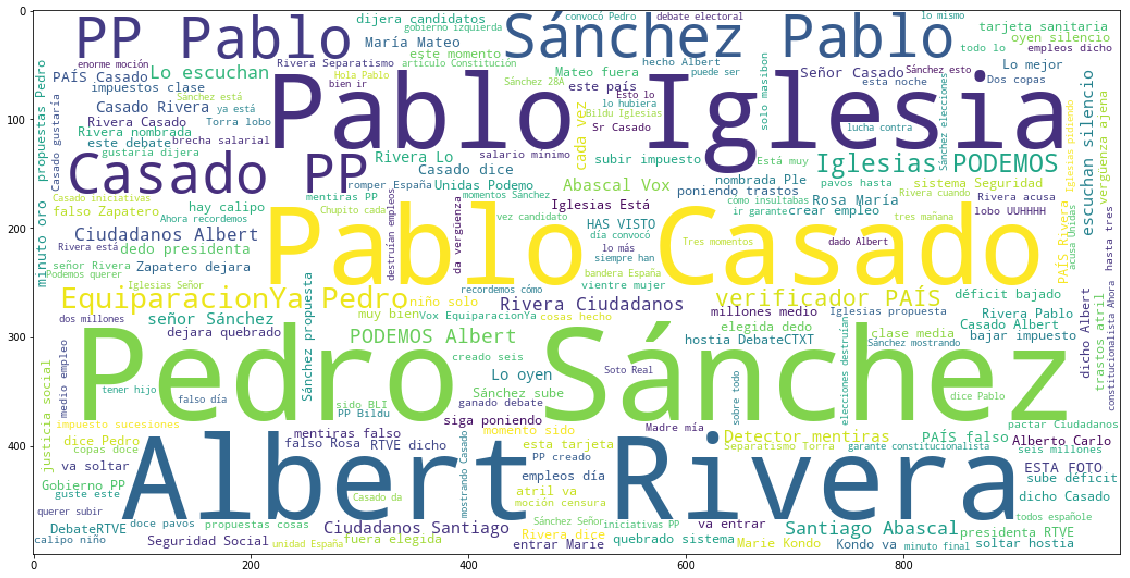

In [21]:
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt
stopwords=set(['el','la','los','las','en','de','con','a','o','desde','entre','para','por','sin','tras','https','ELDEBATEenRTVE','RT','http','es','un','una','unos','unas','que','como','ha','he','no','le','me','se','fue','del','al','co','pero','te','sus','si','no','su'])
def wordCloud(texto,stopwords):
    wordcloud = WordCloud(width=1000, height=500,background_color="white",stopwords=stopwords,random_state=10).generate(texto)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud)
    plt.show()

texto=getTexto()
texto=texto.replace('@Pablo_Iglesias_','Pablo Iglesias')
texto=texto.replace('@sanchezcastejon','Pedro Sánchez')
texto=texto.replace('Pedro Sanchez','Pedro Sánchez')
texto=texto.replace('@Albert_Rivera','Albert Rivera')
texto=texto.replace('@pablocasado_','Pablo Casado')
texto=texto.replace('@Santi_ABASCAL','Santiago Abascal')
texto=texto.replace('@psoe','PSOE')
texto=texto.replace('@populares','PP')
texto=texto.replace('@CiudadanosCs','Ciudadanos')
texto=texto.replace('@ahorapodemos','PODEMOS')
texto=texto.replace('@vox_es','Vox')
texto = re.sub('@[^\s]+','',texto)
texto = re.sub(r"http\S+", "", texto)
textoRTVE=texto
wordCloud(texto,stopwords)

En la figura superior se observa cómo, como cabía esperar, la mayoría de tuits tienen a los dirigentes de partidos políticos que participaron en el debate como protagonistas. Aparecen otros temas relacionados con la política, así como algunas reacciones generales. También queda manifestada la polémica acerca de la presidenta de RTVE, María Mateo.

Podemos eliminar los nombres de los dirigentes de partidos políticos, que claramente han sido lo más mencionado, así como los mismos partidos políticos, para observar mejor qué temas se han discutido más en la red social:

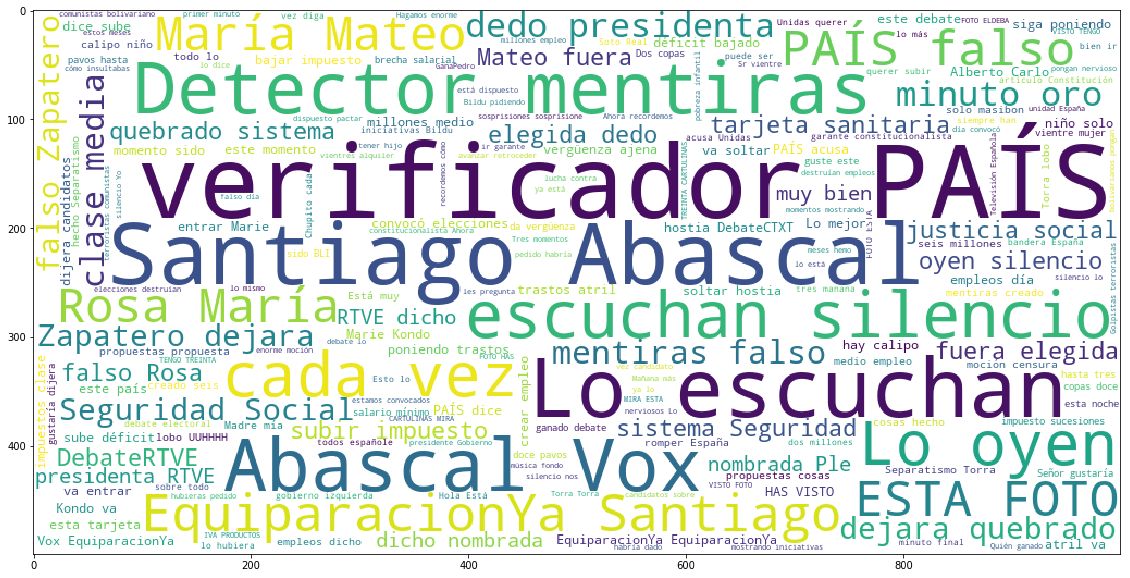

In [5]:
stopwords=set(['el','la','los','las','en','de','con','a','o','desde','entre','para','por','sin','tras','https','ELDEBATEenRTVE','RT','http','es','un','una','unos','unas','que','como','ha','he','no','le','me','se','fue','del','al','co','pero','te','sus','si','no','su','Albert','Rivera','Pablo','Casado','Iglesias','Pedro','Sánchez','jusapol','PSOE','PP','PODEMOS','Ciudadanos'])
def wordCloud(texto,stopwords):
    wordcloud = WordCloud(width=1000, height=500,background_color="white",stopwords=stopwords,random_state=10).generate(texto)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud)
    plt.show()

wordCloud(texto,stopwords)

Puede verse cómo, aun no participando en el debate, el nombre más repetido durante la noche fue el del líder de Vox, Santiago Abascal. También aparece bien visible la presidenta de RTVE, María Mateo, el recurrente término de Pedro Sánchez "Detector de mentiras" y algunos fragmentos del viral minuto de oro de Albert Rivera: "Lo escuchan? Es el silencio". La combinación de palabras más destacada es "verificador País", una serie de publicaciones del periódigo El País que desmentían o ratificaban varias de las afirmaciones de los candidatos al gobierno.

C:\Users\R510V\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  


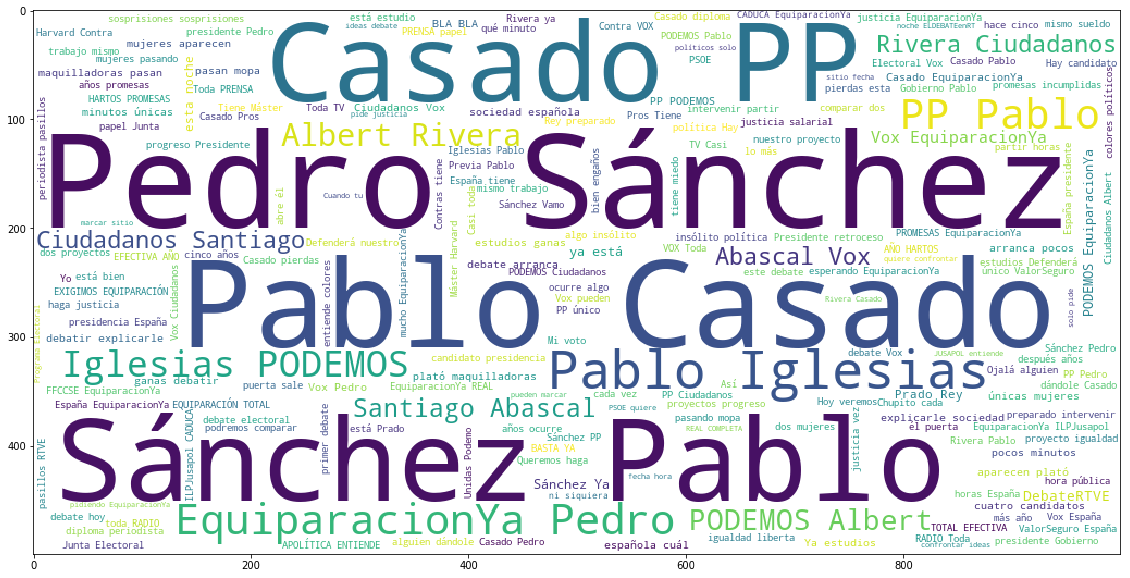

In [6]:
#Extraemos el texto de los tuits previos al debate (media hora antes)
from_date = datetime.datetime(2019, 4, 22, 19, 30, 0, 125000)
to_date = datetime.datetime(2019, 4, 22, 20, 3, 0, 125000)

textoPre = getTexto({"created": {"$gte": from_date, "$lt": to_date}})

stopwords=set(['el','la','los','las','en','de','con','a','o','desde','entre','para','por','sin','tras','https','ELDEBATEenRTVE','RT','http','es','un','una','unos','unas','que','como','ha','he','no','le','me','se','fue','del','al','co','pero','te','sus','si','no','su'])

texto=textoPre
texto=texto.replace('@Pablo_Iglesias_','Pablo Iglesias')
texto=texto.replace('@sanchezcastejon','Pedro Sánchez')
texto=texto.replace('Pedro Sanchez','Pedro Sánchez')
texto=texto.replace('@Albert_Rivera','Albert Rivera')
texto=texto.replace('@pablocasado_','Pablo Casado')
texto=texto.replace('@Santi_ABASCAL','Santiago Abascal')
texto=texto.replace('@psoe','PSOE')
texto=texto.replace('@populares','PP')
texto=texto.replace('@CiudadanosCs','Ciudadanos')
texto=texto.replace('@ahorapodemos','PODEMOS')
texto=texto.replace('@vox_es','Vox')
texto = re.sub('@[^\s]+','',texto)
texto = re.sub(r"http\S+", "", texto)
wordCloud(texto,stopwords)

Se observa cómo antes del debate poca gente hablaba de Albert Rivera, centrándose casi toda la antención en Pedro Sánchez y Pablo Casado. Se observa cómo, efectivamente, no aparece nada relacionado con el desenlace del debate.

C:\Users\R510V\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  


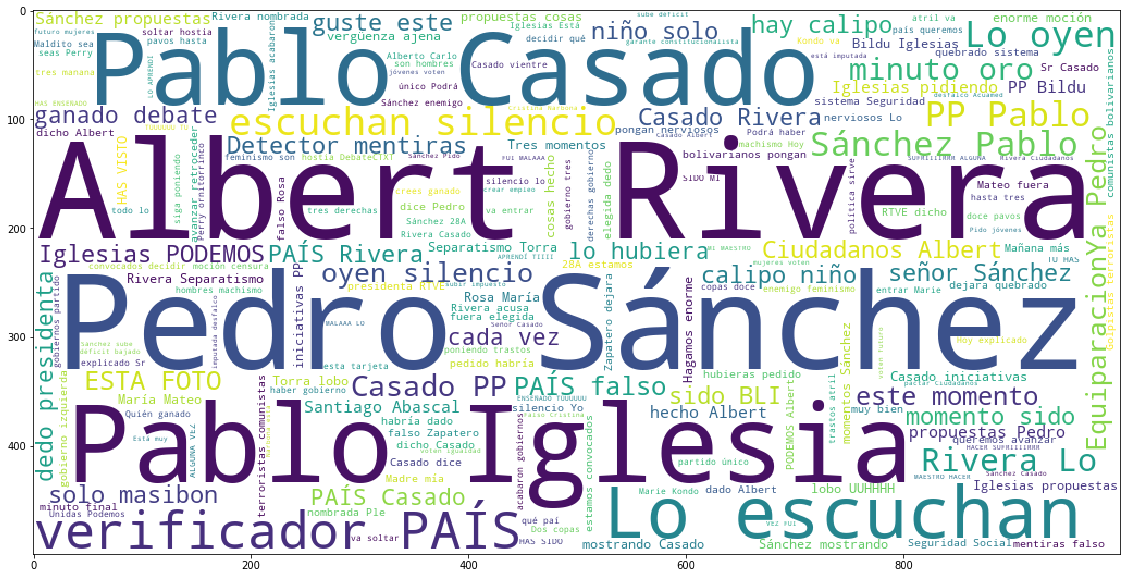

In [7]:
#Extraemos el texto de los tuits sucesivos al debate (hasta una hora después)
from_date = datetime.datetime(2019, 4, 22, 21, 30, 0, 125000)
to_date = datetime.datetime(2019, 4, 22, 22, 30, 0, 125000)

textoPost = getTexto({"created": {"$gte": from_date, "$lt": to_date}})

stopwords=set(['el','la','los','las','en','de','con','a','o','desde','entre','para','por','sin','tras','https','ELDEBATEenRTVE','RT','http','es','un','una','unos','unas','que','como','ha','he','no','le','me','se','fue','del','al','co','pero','te','sus','si','no','su'])

texto=textoPost
texto=texto.replace('@Pablo_Iglesias_','Pablo Iglesias')
texto=texto.replace('@sanchezcastejon','Pedro Sánchez')
texto=texto.replace('Pedro Sanchez','Pedro Sánchez')
texto=texto.replace('@Albert_Rivera','Albert Rivera')
texto=texto.replace('@pablocasado_','Pablo Casado')
texto=texto.replace('@Santi_ABASCAL','Santiago Abascal')
texto=texto.replace('@psoe','PSOE')
texto=texto.replace('@populares','PP')
texto=texto.replace('@CiudadanosCs','Ciudadanos')
texto=texto.replace('@ahorapodemos','PODEMOS')
texto=texto.replace('@vox_es','Vox')
texto = re.sub('@[^\s]+','',texto)
texto = re.sub(r"http\S+", "", texto)
wordCloud(texto,stopwords)

Se observa cómo cambia la situación al fijarse únicamente en los tuits enviados después del debate: Albert Rivera pasa a ser el centro de atención, además de lo dicho durante su "minuto de oro".

Generamos una última nube de palabras, esta vez sólo con lo dicho en idioma catalán:

C:\Users\R510V\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  


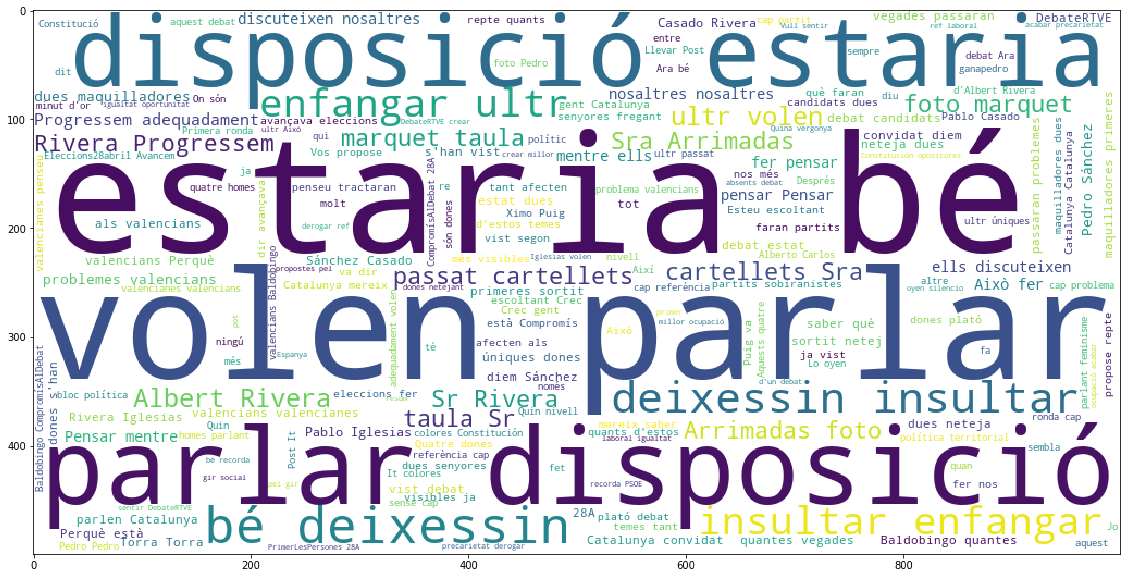

In [8]:
textoCat = getTexto({"language": "ca"})

stopwords=set(['el','la','un','una','i','amb','https','ELDEBATEenRTVE','RT','http','estic','es','és','seu','seva','uns','unes','que','com','ha','he','no','dels','sobre','ho','per','han','tanmateix','hauria','hauríem','ni','li','les','els','mi','em','en','ens','hi','hem','se','de','del','al','co','però','et','si','no'])

texto=textoCat
texto=texto.replace('@Pablo_Iglesias_','Pablo Iglesias')
texto=texto.replace('@sanchezcastejon','Pedro Sánchez')
texto=texto.replace('Pedro Sanchez','Pedro Sánchez')
texto=texto.replace('@Albert_Rivera','Albert Rivera')
texto=texto.replace('@pablocasado_','Pablo Casado')
texto=texto.replace('@Santi_ABASCAL','Santiago Abascal')
texto=texto.replace('@psoe','PSOE')
texto=texto.replace('@populares','PP')
texto=texto.replace('@CiudadanosCs','Ciudadanos')
texto=texto.replace('@ahorapodemos','PODEMOS')
texto=texto.replace('@vox_es','Vox')
texto = re.sub('@[^\s]+','',texto)
texto = re.sub(r"http\S+", "", texto)
wordCloud(texto,stopwords)

Al observar tan solo lo que se dice en catalán, los resultados son sorprendentemente distintos: los cuatro candidatos que participaban en el debate pierden el protagonismo, que pasa a formar parte de la disposición y el deseo de "hablar".

## Evolución en el tiempo

Analizaremos ahora cómo evolucionó el protagonismo de los candidatos durante la noche:

In [9]:
def getTweetInfo(query={}):
    cursor = collection.find(query,no_cursor_timeout=True)
    tweets=[]
    marcapaginas=0
    it=0
    lenTotal=cursor.count()
    continuar=True
    while continuar==True:
        for i,tweet in enumerate(cursor):
            try:
                tweets.append(tweet)
                it+=1
            except:
                break

        #La iteración sobre el cursor falla cuando se refresca el caché- Con corsor.retrieved puede determinarse por qué índice se quedó el programa, para de esta forma no empezar de cero la próxima vez
        marcapaginas=marcapaginas+cursor.retrieved
        if it<lenTotal:
            cursor = collection.find(query,no_cursor_timeout=True)[marcapaginas-1:]
        else: 
            cursor.close()
            continuar=False
    return tweets

In [10]:
#Creamos una variable con los tweets separados por fecha
alltweets=getTweetInfo()

#Se crea un dataframe con todos los tweets, de los cuales seleccionamos la fecha
dataTweets=pd.DataFrame(alltweets)
fechas=dataTweets['created']
idx=pd.DatetimeIndex(fechas)

C:\Users\R510V\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  


C:\Users\R510V\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  
C:\Users\R510V\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


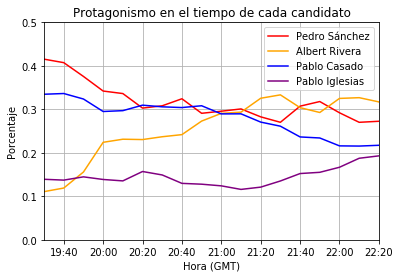

In [11]:
#Creamos una variable con el texto de los tweets separados por fecha
import pandas as pd
import time
import matplotlib.dates as mdates

alltweets=getTweetInfo()

#Se crea un dataframe con todos los tweets, de los cuales seleccionamos la fecha
dataTweets=pd.DataFrame(alltweets)
fechas=dataTweets['created']
idx=pd.DatetimeIndex(fechas)

#Construimos una serie con los tweets separados por intervalos de 10 minutos
Psanchez=[]
Arivera=[]
Pcasado=[]
Piglesias=[]
for i in np.arange(len(dataTweets)):
    rownow=dataTweets['fulltext'][i]
    rownow=rownow.replace('@Pablo_Iglesias_','Pablo Iglesias')
    rownow=rownow.replace('@sanchezcastejon','Pedro Sánchez')
    rownow=rownow.replace('Pedro Sanchez','Pedro Sánchez')
    rownow=rownow.replace('@Albert_Rivera','Albert Rivera')
    rownow=rownow.replace('@pablocasado_','Pablo Casado')
    rownow=rownow.replace('@psoe','PSOE')
    rownow=rownow.replace('@populares','PP')
    rownow=rownow.replace('@CiudadanosCs','Ciudadanos')
    rownow=rownow.replace('@ahorapodemos','PODEMOS')

    Psanchez.append(rownow.count("Sánchez")+rownow.count("PSOE"))
    Arivera.append(rownow.count("Rivera")+rownow.count("Cs")+rownow.count("Ciudadanos"))
    Pcasado.append(rownow.count("Casado")+rownow.count("PP"))
    Piglesias.append(rownow.count("Iglesias")+rownow.count("Podemos"))

ts_Psanchez = pd.Series(Psanchez,index=idx)
ts_Arivera = pd.Series(Arivera,index=idx)
ts_Pcasado = pd.Series(Pcasado,index=idx)
ts_Piglesias = pd.Series(Piglesias,index=idx)

normalizador=ts_Psanchez.resample('10Min').sum()+ts_Arivera.resample('10Min').sum()+ts_Pcasado.resample('10Min').sum()+ts_Piglesias.resample('10Min').sum()

ts_Psanchez=ts_Psanchez.resample('10Min').sum()/normalizador
ts_Arivera=ts_Arivera.resample('10Min').sum()/normalizador
ts_Pcasado=ts_Pcasado.resample('10Min').sum()/normalizador
ts_Piglesias=ts_Piglesias.resample('10Min').sum()/normalizador

fig, ax = plt.subplots()
ax.grid(True)
ax.set_title("Protagonismo en el tiempo de cada candidato")
hours = mdates.MinuteLocator(interval=20)
date_formatter = mdates.DateFormatter('%H:%M')

datemin = datetime.datetime(2019, 4, 22, 19, 30, 0, 125000)
datemax = datetime.datetime(2019, 4, 22, 22, 20, 0, 125000)

ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(date_formatter)
ax.set_xlim(datemin,datemax)
ax.set_ylim(0,0.5)
ax.set_xlabel("Hora (GMT)")
ax.set_ylabel("Porcentaje")
#max_freq=sum_ts_texto.max()

ax.plot(ts_Psanchez,color="Red",label="Pedro Sánchez")
ax.plot(ts_Arivera,color="Orange",label="Albert Rivera")
ax.plot(ts_Pcasado,color="Blue",label="Pablo Casado")
ax.plot(ts_Piglesias,color="Purple",label="Pablo Iglesias")
ax.legend(loc='best')

Debido a algunas limitaciones en la captura de tweets, el número de tweets que se pudieron captar en cada momento varió levemente. Debido a esto, representar las series en valores absolutos no refleja la realidad. Para solucionarlo, las series se han representado en términos relativos.

Se observa cómo Pablo Iglesias fue, en general, el candidato menos mencionado durante las dos horas. Mientras que Albert Rivera fue ganando "popularidad" durante la noche, Pablo Casado y Pedro Sánchez fueron perdiéndola.

## Comparación entre debates 22A y 23A

Ya que también se han recogido tuits del debate que tuvo lugar el día siguiente en Antena 3, se realiza una última comparación entre la frecuencia de aparición de los nombres de los cinco partidos políticos más mencionados del momento y de sus respectivos dirigentes.

In [17]:
connection = pymongo.MongoClient('localhost', 27017)
db = connection.TwitterStream
db.Antena3.ensure_index("id", unique=True, dropDups=True)
collection = db.A3media

cursor = collection.find(no_cursor_timeout=True) 

C:\Users\R510V\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: ensure_index is deprecated. Use create_index instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
stopwords=set(['el','la','los','las','en','de','con','a','o','desde','entre','para','por','sin','tras','https','ELDEBATEenRTVE','RT','http','es','un','una','unos','unas','que','como','ha','he','no','le','me','se','fue','del','al','co','pero','te','sus','si','no','su'])

texto=getTexto()
texto=texto.replace('@Pablo_Iglesias_','Pablo Iglesias')
texto=texto.replace('@sanchezcastejon','Pedro Sánchez')
texto=texto.replace('Pedro Sanchez','Pedro Sánchez')
texto=texto.replace('@Albert_Rivera','Albert Rivera')
texto=texto.replace('@pablocasado_','Pablo Casado')
texto=texto.replace('@Santi_ABASCAL','Santiago Abascal')
texto=texto.replace('@psoe','PSOE')
texto=texto.replace('@populares','PP')
texto=texto.replace('@CiudadanosCs','Ciudadanos')
texto=texto.replace('@ahorapodemos','PODEMOS')
texto=texto.replace('@vox_es','Vox')
texto = re.sub('@[^\s]+','',texto)
texto = re.sub(r"http\S+", "", texto)
textoA3 = texto

C:\Users\R510V\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  


Text(0.5, 1.0, 'Porcentaje de menciones a cada candidato en cada debate')

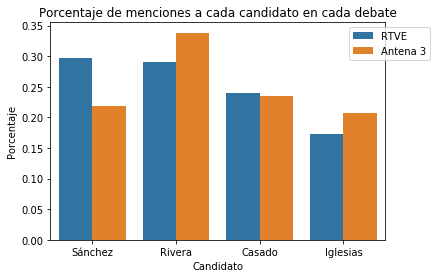

In [22]:
import seaborn as sns

candidatos=["Sánchez","Rivera","Casado","Iglesias","Sánchez","Rivera","Casado","Iglesias"]
debates=["RTVE","RTVE","RTVE","RTVE","Antena 3","Antena 3","Antena 3","Antena 3"]
totalRTVE=textoRTVE.count("Sánchez")+textoRTVE.count("Rivera")+textoRTVE.count("Casado")+textoRTVE.count("Iglesias")
totalA3=textoA3.count("Sánchez")+textoA3.count("Rivera")+textoA3.count("Casado")+textoA3.count("Iglesias")
numero=[textoRTVE.count("Sánchez")/totalRTVE,textoRTVE.count("Rivera")/totalRTVE,textoRTVE.count("Casado")/totalRTVE
        ,textoRTVE.count("Iglesias")/totalRTVE,textoA3.count("Sánchez")/totalA3,textoA3.count("Rivera")/totalA3,
        textoA3.count("Casado")/totalA3,textoA3.count("Iglesias")/totalA3]
bothDeb=pd.DataFrame({"candidatos":candidatos,"debates":debates,"numero":numero})

g = sns.barplot(x='candidatos', y='numero', hue='debates', data=bothDeb)
plt.legend(bbox_to_anchor=(1.15, 1),loc='best')
plt.xlabel('Candidato')
plt.ylabel('Porcentaje')
plt.title('Porcentaje de menciones a cada candidato en cada debate')

En esta última figura se observa cómo el protagonismo de los disintos candidatos fue diferente durante cada debate. El caso más destacable es el de Pedro Sánchez, de quien se habló mucho más durante el debate de RTVE.